<h1>
  Pricing options and computing implied volatilities using Neural Networks
</h1>

---

### **Importing necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### **Dataset Generation**

Dataset is created using 3 methods
1. Black-Scholes model
2. Heston model
3. Brent’s method will be used to find
the corresponding implied volatility

In [ ]:
def Black_Scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    Call_Prices = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Call_Prices

# Parameters for the dataset
n_samples = 1000
np.random.seed(42)

# Generate random values for the parameters
S = np.random.uniform(50, 500, n_samples)       # Stock price
K = np.random.uniform(50, 500, n_samples)       # Strike price
T = np.random.uniform(0.1, 5, n_samples)        # Time to maturity in years
r = np.random.uniform(0.01, 0.08, n_samples)    # Risk-free interest rate
sigma = np.random.uniform(0.1, 0.5, n_samples)  # Volatility

# Calculate the call option prices using the Black-Scholes equation
call_prices = Black_Scholes(S, K, T, r, sigma)

# Create a DataFrame to store the dataset
df = pd.DataFrame({
    'Stock Price (S)': S,
    'Strike Price (K)': K,
    'Time to Maturity (T)': T,
    'Risk-Free Rate (r)': r,
    'Volatility (sigma)': sigma,
    'Call Option Price': call_prices
})
df.to_csv('options_data.csv', index=False)

###  **Artifitial Neural Network**

*Table 2. The Selected Model After the Random Search*

<div>
    <style>
        table {
            border-collapse: collapse;
            width: 50%;
            margin: 20px auto;
            font-family: Arial, sans-serif;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
    <table>
        <thead>
            <tr>
                <th>Parameter</th>
                <th>Option</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Hidden layers</td>
                <td>4</td>
            </tr>
            <tr>
                <td>Neurons (each layer)</td>
                <td>400</td>
            </tr>
            <tr>
                <td>Activation</td>
                <td>ReLU</td>
            </tr>
            <tr>
                <td>Dropout rate</td>
                <td>0.0</td>
            </tr>
            <tr>
                <td>Batch-normalization</td>
                <td>No</td>
            </tr>
            <tr>
                <td>Initialization</td>
                <td>Glorot_uniform</td>
            </tr>
            <tr>
                <td>Optimizer</td>
                <td>Adam</td>
            </tr>
            <tr>
                <td>Batch size</td>
                <td>1024</td>
            </tr>
        </tbody>
    </table>
</div>

In [ ]:
'''
Initialization of Artifitial Neural Network
'''
model = models.Sequential()

'''
Input layer {
    S: Current stock price.
    K: Strike price.
    T: Time to maturity.
    r: Risk-free interest rate.
    σ: Volatility of the stock's returns.
}
'''
model.add(layers.Input(shape=(5,)))

'''
4 Hidden Layers for each 400 neurons and Initialized the Weight using Glorot_uniform for better convergence.
'''
model.add(layers.Dense(400, activation='relu', kernel_initializer='glorot_uniform'))
model.add(layers.Dense(400, activation='relu', kernel_initializer='glorot_uniform'))
model.add(layers.Dense(400, activation='relu', kernel_initializer='glorot_uniform'))
model.add(layers.Dense(400, activation='relu', kernel_initializer='glorot_uniform'))

'''
Output Layer: The output of the model is the Option Price
'''
model.add(layers.Dense(1, activation='linear'))

#### *Learning Rate Schedular*

The learning rate `LR(t)` at time `t` can be calculated using the following formula:

    LR(t) = LR_min + 0.5 * (LR_max - LR_min) * (1 + cos(t * pi / step_size))

Where:
- `LR_min` = Minimum learning rate
- `LR_max` = Maximum learning rate
- `step_size` = Number of iterations or epochs in one cycle
- `t` = Current iteration or epoch
- `pi` = Pi, approximately 3.14159

In this formula:
- The cosine function provides a smooth transition between `LR_min` and `LR_max`.
- The learning rate starts at `LR_min`, increases to `LR_max`, and then decreases back to `LR_min` over each cycle.

In [ ]:
class CyclicLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLearningRate, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        cycle = tf.floor(1 + step / (2 * self.step_size))
        x = tf.abs(step / self.step_size - 2 * cycle + 1)

        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * tf.maximum(0.0, (1 - x))
        elif self.mode == 'triangular2':
            lr = self.base_lr + (self.max_lr - self.base_lr) * tf.maximum(0.0, (1 - x)) / (2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            lr = self.base_lr + (self.max_lr - self.base_lr) * tf.maximum(0.0, (1 - x)) * (0.9999 ** step)
        elif self.mode == 'cosine':
            lr = self.base_lr + ((self.max_lr - self.base_lr) * (1 + tf.math.cos(np.pi * x))) / 2
        else:
            raise ValueError("Unsupported mode: {}".format(self.mode))

        return lr

In [ ]:
# Define parameters
LR_min = 1e-5
LR_max = 1e-2
step_size = 200
SchedularType = 'cosine'   # Other options: 'triangular', 'triangular2'
# Define CLR schedule
clr_schedule = CyclicLearningRate(
    base_lr=LR_min,
    max_lr=LR_max,
    step_size=step_size,
    mode=SchedularType
)

#### *Setting up optimizers & compiling model*

In [ ]:
# Use CLR with an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=clr_schedule)

# Compile model with the optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_absolute_error'])

### **Training and Testing**

In [ ]:
Dataset = pd.read_csv('/content/options_data.csv')
y = Dataset['Call Option Price'].values
X = Dataset.drop('Call Option Price', axis=1).values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)
scaller = StandardScaler()
X_train = scaller.fit_transform(X_train)
X_test = scaller.transform(X_test)

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2)

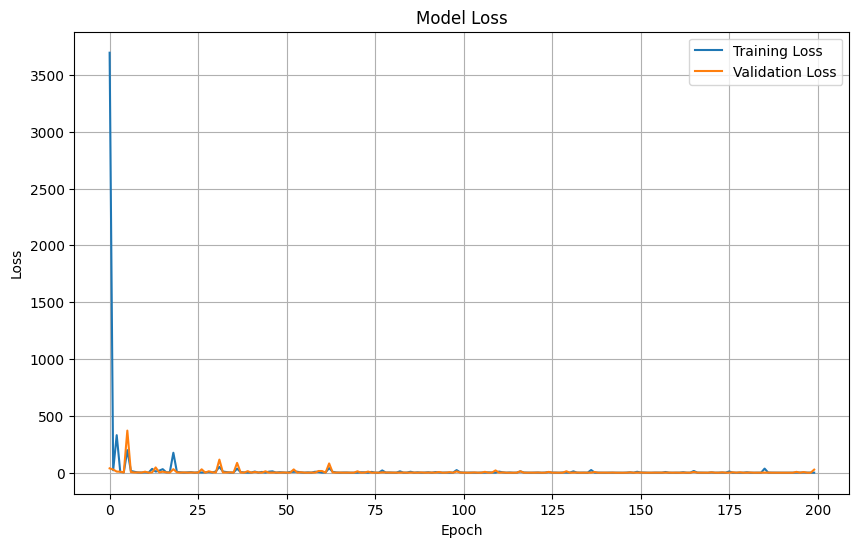

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
  print(y_test[i],y_pred[i])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
132.51847369510233 [125.15892]
57.26550181306362 [56.181366]
218.2477839363511 [212.49438]
1.2419683940183e-07 [-0.34957027]
25.94397620255819 [24.333899]
114.37728294404474 [110.922745]
1.6019928520552806 [1.8348697]
152.04160314168405 [146.92178]
93.1108297615934 [88.917244]
0.0012061082703466 [-0.07730412]
172.91133858686533 [159.5792]
261.79430300931 [255.01447]
35.19112217562376 [35.66169]
108.10544429663518 [100.9324]
3.10058345607969 [2.9940743]
4.45668811204332 [4.0650487]
66.72351137645181 [63.97789]
256.126100412245 [248.74377]
198.2301304417311 [190.74246]
63.137853122864186 [61.683258]
213.15439858303645 [209.3964]
6.793476584737685e-17 [-0.4279158]
193.6945050669642 [188.2049]
160.22487466580458 [156.87976]
196.4886709597037 [189.31375]
29.120630142435655 [29.796896]
114.75138714570409 [108.46895]
145.37059952971202 [140.4865]
101.1956333882597 [95.52559]
54.276563844365285 [54.82153]
236.38787065600783 [232.82108]
0.942177632672228 [1